In [27]:
import torch
import os
import matplotlib.pyplot as plt
from monai.metrics import DiceMetric, compute_dice
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    Rotate90d,
    RemoveSmallObjectsd,
    ClipIntensityPercentilesd,
    ScaleIntensityd,
    OneOf,
)
from monai.data import decollate_batch
from src.model import sam_model_registry
import numpy as np
from typing import Optional
from src.utils import (
    prepare_sam_training_input,
    # prepare_sam_val_input_cp_only,
    prepare_sam_val_input_pp_only,
    prepare_sam_val_input_bb_only,
)
from dataclasses import dataclass

from src.utils import apply_coords_torch, apply_coords_bbox

np.set_printoptions(formatter={"float": "{: 0.3f}".format}, suppress=True)

from monai.transforms.utils import generate_spatial_bounding_box, get_extreme_points

In [2]:
def show_anns(
    masks, input_point, input_box, input_label, filename, image
):
    if len(masks) == 0:
        return

    for i, mask in enumerate(masks):
        plt.figure(figsize=(10, 10))
        plt.imshow(image, cmap="gray")
        show_mask(mask, plt.gca())
        if input_box is not None:
            show_box(input_box, plt.gca())
        if (input_point is not None) and (input_label is not None):
            show_points(input_point, input_label, plt.gca())

        plt.axis("off")
#        plt.savefig(
#            filename + "_" + str(i) + ".png", bbox_inches="tight", pad_inches=-0.1
#        )
        plt.show()
        plt.close()


def show_mask(mask, ax, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 1],
        pos_points[:, 0],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 1],
        neg_points[:, 0],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

In [3]:
checkpoint = './checkpoint/model_best.pt'

In [4]:
model = sam_model_registry['tiny_vit'](
    checkpoint=None,
    image_size=1024,
    encoder_in_chans=27,
    mod='sam'
)

In [5]:
model_state = torch.load(checkpoint, map_location="cpu")

In [6]:
model_state = torch.load(checkpoint, map_location="cpu")["state_dict"]
model.load_state_dict(model_state)

<All keys matched successfully>

In [113]:
post_label = AsDiscrete(to_onehot=115)
post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
dice_score = DiceMetric(include_background=False, reduction='mean', get_not_nans=False,return_with_label=False)

In [8]:
imagen_1 = [
    {
        "image": "../../../Dataset/total_liifa/imagesTr/s0019.nii.gz",
        "label": "../../../Dataset/total_liifa/labelsTr/s0019.nii.gz",
    } #
]
imagen_2 = [
    {
        "image": "../../../Dataset/total_liifa/imagesTr/s0140.nii.gz",
        "label": "../../../Dataset/total_liifa/labelsTr/s0140.nii.gz",
    } #10
]
imagen_3 = [
    {
        "image": "../../../Dataset/total_liifa/imagesTr/s0500.nii.gz",
        "label": "../../../Dataset/total_liifa/labelsTr/s0500.nii.gz",
    } #110
]

In [9]:
test_transform = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Rotate90d(keys=["image", "label"], k=1),
#        Spacingd(
#            keys=["image", "label"],
#            pixdim=(1, 1, 1),
#            mode=("bilinear", "nearest"),
#            lazy=False,
#        ),
         ClipIntensityPercentilesd(keys=["image"], lower=0.5, upper=99.5),
         ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
         ),
        #ScaleIntensityRanged(
        #    keys=["image"], a_min=-1024, a_max=1024, b_min=0.0, b_max=1.0, clip=True
        # ),
#        RemoveSmallObjectsd(
#            keys=["label"],
#            min_size=100,
#            connectivity=8,
#        ),
        OneOf(transforms=[
            Rotate90d(keys=["image", "label"], k=0),
            Rotate90d(keys=["image", "label"], k=1,spatial_axes=(0,2)),
            Rotate90d(keys=["image", "label"], k=1,spatial_axes=(1,2)),
        ])
    ]
)

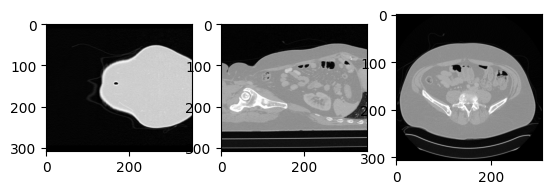

In [10]:
data = test_transform(imagen_3[0])
imagen, label = data["image"], data["label"]
fig, ax = plt.subplots(1, 3)
ax[0].imshow(imagen[0, 65, :, :], cmap="gray")
ax[1].imshow(imagen[0, :, 100, :], cmap="gray")
ax[2].imshow(imagen[0, :, :, 150], cmap="gray")

# plt.colorbar()

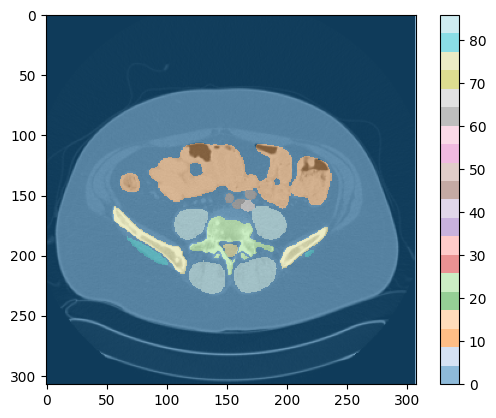

In [11]:
plt.imshow(imagen[0, :, :, 150], cmap="gray")
plt.pcolormesh(label[0, :, :, 150], alpha=0.5, cmap='tab20')
plt.colorbar()

In [12]:

liifa_labels = {
            0: "background",
            1: "spleen",
            2: "kidney_right",
            3: "kidney_left",
            4: "gallbladder",
            5: "liver",
            6: "stomach",
            7: "pancreas",
            8: "adrenal_gland_right",
            9: "adrenal_gland_left",
            10: "lung_left",
            11: "lung_right",
            12: "esophagus",
            13: "trachea",
            14: "thyroid_gland",
            15: "small_bowel",
            16: "duodenum",
            17: "colon",
            18: "urinary_bladder",
            19: "prostate",
            20: "kidney_cyst_left",
            21: "kidney_cyst_right",
            22: "sacrum",
            23: "vertebrae",
            24: "heart",
            25: "humerus_left",
            26: "humerus_right",
            27: "scapula_left",
            28: "scapula_right",
            29: "clavicula_left",
            30: "clavicula_right",
            31: "femur_left",
            32: "femur_right",
            33: "hip_left",
            34: "hip_right",
            35: "spinal_cord",
            36: "brain",
            37: "skull",
            38: "ribs",
        }

In [13]:
@dataclass
class config:
    max_points: int
    skip_bk: bool
    num_prompt: int
    distributed: bool
    label_prompt: bool
    bbox_prompt: bool
    point_prompt: bool

In [14]:
config = config(max_points=5, skip_bk=True, num_prompt=2, distributed=False, label_prompt=False, bbox_prompt=True, point_prompt=True)

In [15]:
def prepare_data(imagen, label, slice):
    imagen = imagen.squeeze()
    label = label.squeeze()
    imagen = imagen[..., slice - 9 //2 : slice + 9 // 2 + 1].permute(2, 0, 1)
    label = label[..., slice - 9 //2 : slice + 9 // 2 + 1][..., 9 // 2]
    return imagen, label

In [16]:
def inference(
    image,
    labels,
    model,
    prompt: str = "point",
    config=None,
    n_point: int = 1,
):
    model.eval()
    with torch.no_grad():
        if prompt == "point":
            data, target, _ = prepare_sam_val_input_pp_only(
                image, labels, config, 1024, n_point, 1
            )
        elif prompt == "bbox":
            data, target, _ = prepare_sam_val_input_bb_only(image, labels)
        
        with torch.cuda.amp.autocast():
            output = model(data)

        output = torch.argmax(post_pred(output[0]['high_res_logits']),dim=0)
        #output = post_pred(output[0]["high_res_logits"])
        return output, data

In [183]:
image_i, label_i = prepare_data(imagen, label, 100)

In [184]:
prueba, data = inference(image=image_i, labels=label_i, model=model, config=config, prompt='bbox', n_point=9) 

/Users/ignacio.scarinci/mambaforge/envs/sam/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [205]:
prueba = torch.where(prueba > 0, prueba+1, 0)

In [206]:
y_pred = post_label(prueba)
y = post_label(label_i.unsqueeze(0))

In [218]:
y_pred.shape

torch.Size([115, 307, 307])

array([ 0.000,  17.000,  22.000,  62.000,  63.000,  64.000,  65.000,
        74.000,  75.000,  77.000,  78.000,  79.000,  80.000,  81.000,
        82.000,  85.000,  86.000], dtype=float32)

In [209]:
np.where(y_pred==1)

(array([ 0,  0,  0, ..., 86, 86, 86]),
 array([  0,   0,   0, ..., 175, 175, 175]),
 array([  0,   1,   2, ..., 192, 193, 194]))

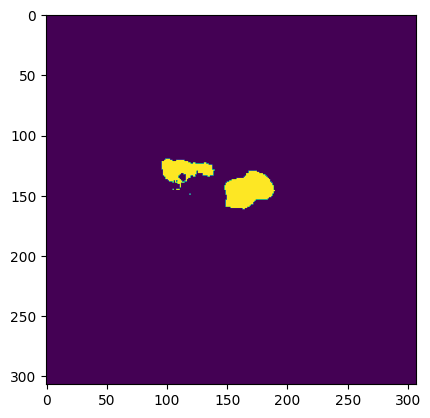

In [211]:
plt.imshow(y_pred[17, :, :])

In [223]:
acc_batch=compute_dice(y_pred.unsqueeze(0),y.unsqueeze(0))

In [224]:
acc_batch

metatensor([[0.9845,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.8514,
            nan,    nan,    nan,    nan, 0.8536,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.9157,
         0.9587, 0.8861, 0.9032,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan, 0.9571, 0.9548,    nan, 0.8804, 0.9387, 0.8706, 0.9272,
         0.7854, 0.4103,    nan,    nan, 0.8737, 0.5065,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,

: 

In [70]:
acc_sum, not_nans = (
                        torch.nansum(acc_batch).item(),
                      115 - torch.sum(torch.isnan(acc_batch).float()).item(),
                    )

In [71]:
acc_sum/not_nans

-2.662779257331096

In [41]:
label_decollate = post_label(prueba)
label_in = post_label(label_in)
label_decollate.shape

torch.Size([115, 307, 307])

In [42]:
dice_score(label_decollate, label_i)

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

In [167]:
image_pre = model.preprocess(image_i)

In [117]:
apply_coords_bbox(data[0]["boxes"][34], 1024, 316)

KeyError: 'boxes'

In [141]:
np.unique(label_i)

array([ 0.000,  87.000,  88.000], dtype=float32)

In [142]:
np.unique(prueba)

array([ 0, 86, 87])

In [120]:
prueba = np.where(prueba>1, prueba+1, prueba)

In [121]:
show_anns(
    prueba == 22,
    #apply_coords_torch(data[0]["point_coords"][37], 1024, 316),
    None,
    #apply_coords_bbox(data[0]["boxes"][1], 1024,316),
    #data[0]["point_labels"][22].numpy(),
    #None,
    None,
    None,
    image_i[9 // 2, ...].numpy(),
)

TypeError: show_anns() missing 1 required positional argument: 'image'

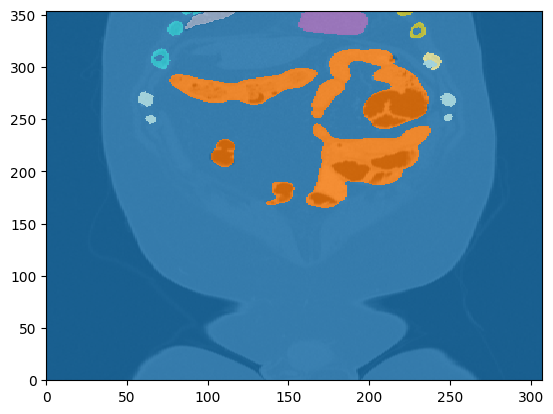

In [160]:
plt.pcolormesh(np.rot90(image_i[9//2,:, :].numpy(), k=2), cmap='gray')
plt.pcolormesh(np.rot90(label_i[:, :], k=2), alpha=0.8, cmap='tab20')

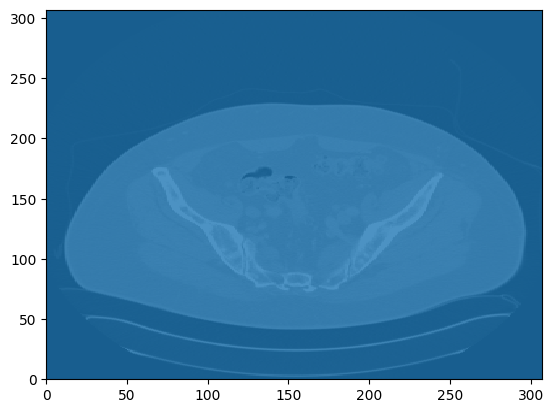

In [46]:
plt.pcolormesh(np.rot90(image_i[9 // 2, :, :].numpy(), k=-2), cmap="gray")
plt.pcolormesh(np.rot90(label_decollate[32,:,:], k=-2), alpha=0.8, cmap="tab20")

In [169]:
data, target, target_original, skip = prepare_sam_training_input(image_i, label_i, config, model, 1024, 0, 1)

In [170]:
data_process = model.preprocess(image_i, is_input=True)

In [171]:
label_process = model.preprocess(label_i[4,...], is_input=True)

In [42]:
label_process.shape

torch.Size([948, 1024, 1024])

ValueError: not enough values to unpack (expected 2, got 1)

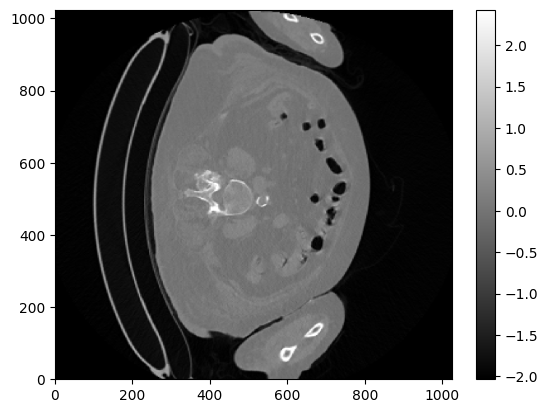

In [41]:
plt.pcolormesh(data_process[9 // 2, ...], cmap="gray")
plt.colorbar()
plt.pcolormesh(label_process[1, 0, ...], alpha=0.8, cmap="tab20")

In [37]:
label_i[...].shape

torch.Size([316, 316])

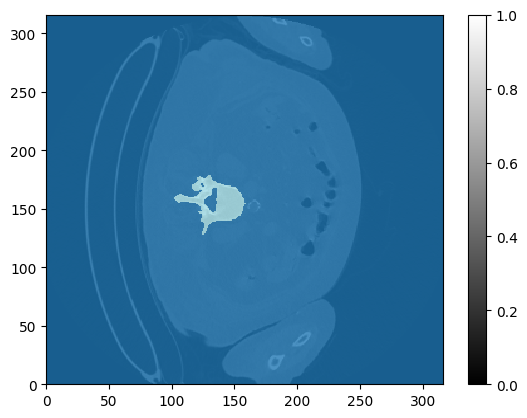

In [52]:
plt.pcolormesh(image_i[9 // 2, ...], cmap="gray")
plt.colorbar()
plt.pcolormesh(label_i[...] == 23, alpha=0.8, cmap="tab20")

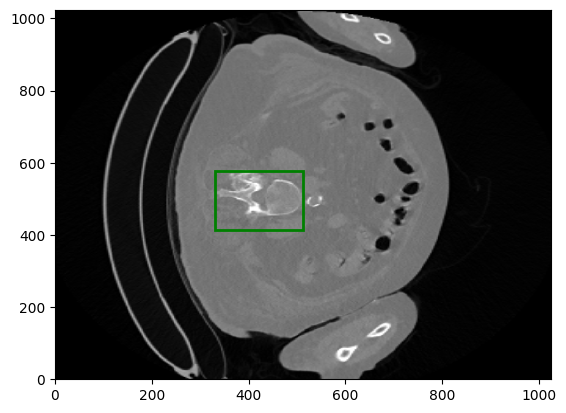

In [47]:
fig, ax = plt.subplots(1, 1)
ax.pcolormesh(data_process[9 // 2, ...], cmap="gray")
x0, y0 = data[0]['boxes'][22,1], data[0]['boxes'][22,0]
w, h = data[0]['boxes'][22,3] - data[0]['boxes'][22,1], data[0]['boxes'][22,2] - data[0]['boxes'][22,0]
ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

In [37]:
np.unique(label_i)

array([ 0.000,  15.000,  17.000,  23.000,  35.000], dtype=float32)

In [80]:
mask = label_i[...] == 5

In [54]:
active_px = torch.nonzero(mask.as_tensor())

In [55]:
active_px

tensor([[128, 124],
        [128, 125],
        [129, 124],
        ...,
        [177, 130],
        [178, 129],
        [178, 130]])

In [56]:
min_coord, _ = torch.min(active_px, dim=0)
max_coord, _ = torch.max(active_px, dim=0)


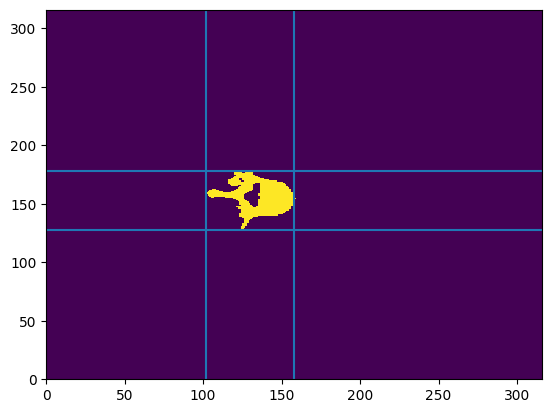

In [24]:
plt.pcolormesh(mask)
plt.hlines(min_coord[0].numpy(), 0, mask.shape[1])
plt.vlines(min_coord[1].numpy(), 0, mask.shape[1])
plt.hlines(max_coord[0].numpy(), 0, mask.shape[1])
plt.vlines(max_coord[1].numpy(), 0, mask.shape[1])

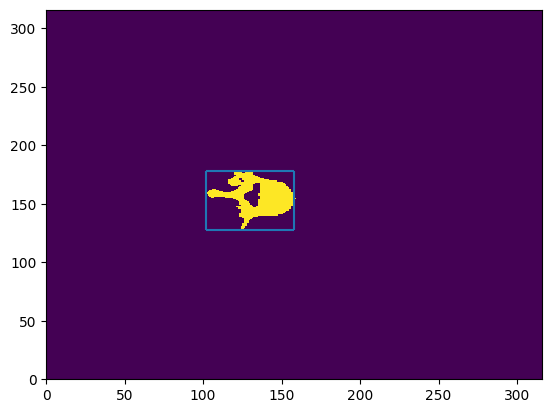

In [25]:
plt.pcolormesh(mask)
plt.hlines(min_coord[0].numpy(), min_coord[1], max_coord[1])
plt.vlines(min_coord[1].numpy(), min_coord[0], max_coord[0])
plt.hlines(max_coord[0].numpy(), min_coord[1], max_coord[1])
plt.vlines(max_coord[1].numpy(), min_coord[0], max_coord[0])

In [26]:
h_b, w_b = abs(max_coord[0] - min_coord[0]), abs(max_coord[1] - min_coord[1])

In [27]:
noise_std = min(h_b, w_b) * 0.1

In [28]:
noise_std

metatensor(5.)

In [29]:
max_noise = min(15, int(noise_std * 15))

In [30]:
noise_x = torch.randint(low=-max_noise, high=max_noise, size=[1])
noise_y = torch.randint(low=-max_noise, high=max_noise, size=[1])

In [31]:
x0, y0 = min_coord[0] + noise_x, min_coord[1] + noise_y
x1, y1 = max_coord[0] + noise_x, max_coord[1] + noise_y

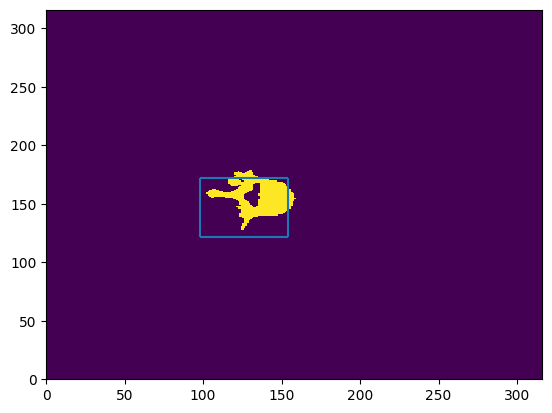

In [32]:
plt.pcolormesh(mask)
plt.hlines(x0.numpy(), y0, y1)
plt.vlines(y0.numpy(), x0, x1)
plt.hlines(x1.numpy(), y0, y1)
plt.vlines(y1.numpy(), x0, x1)

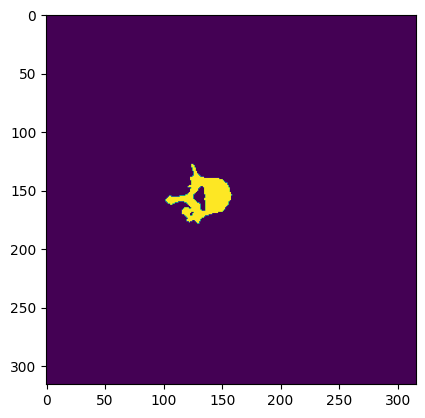

In [29]:
plt.imshow(mask)

In [91]:
(x0, y0), (x1, y1) = generate_spatial_bounding_box(mask.unsqueeze(dim=0), allow_smaller=False, margin=10)

In [87]:
label_i.shape

torch.Size([316, 316])

In [92]:
x0

0

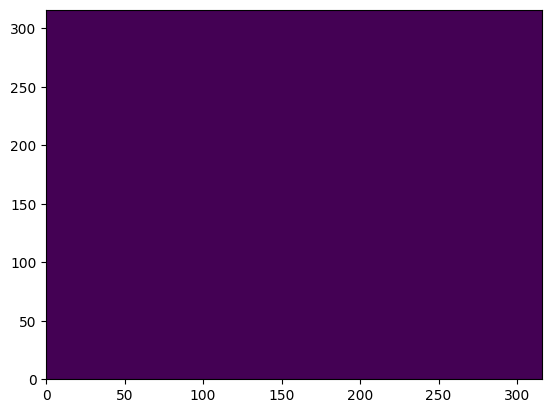

In [89]:
fig, ax = plt.subplots(1,1)
ax.pcolormesh(mask)
ax.add_patch(
        plt.Rectangle((bbox[0][1], bbox[0][0]), bbox[1][1]-bbox[0][1], bbox[1][0]-bbox[0][0] , edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
)

In [71]:
unique_labels = torch.tensor([i for i in range(1, 39)])

In [74]:
batch_labels = torch.stack(
        [label_i == unique_labels[i] for i in range(len(unique_labels))], dim=0
    ).float()

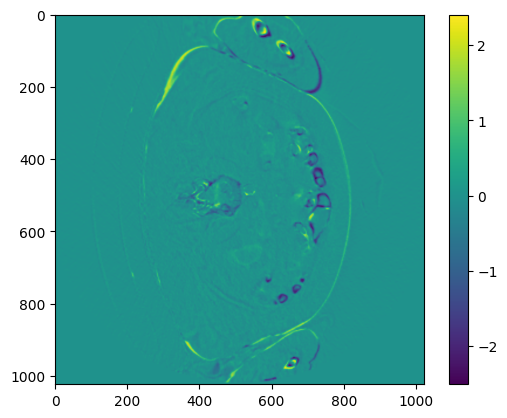

In [44]:
plt.imshow(image_pre[10, :, :]-image_pre[1, :, :])
plt.colorbar()

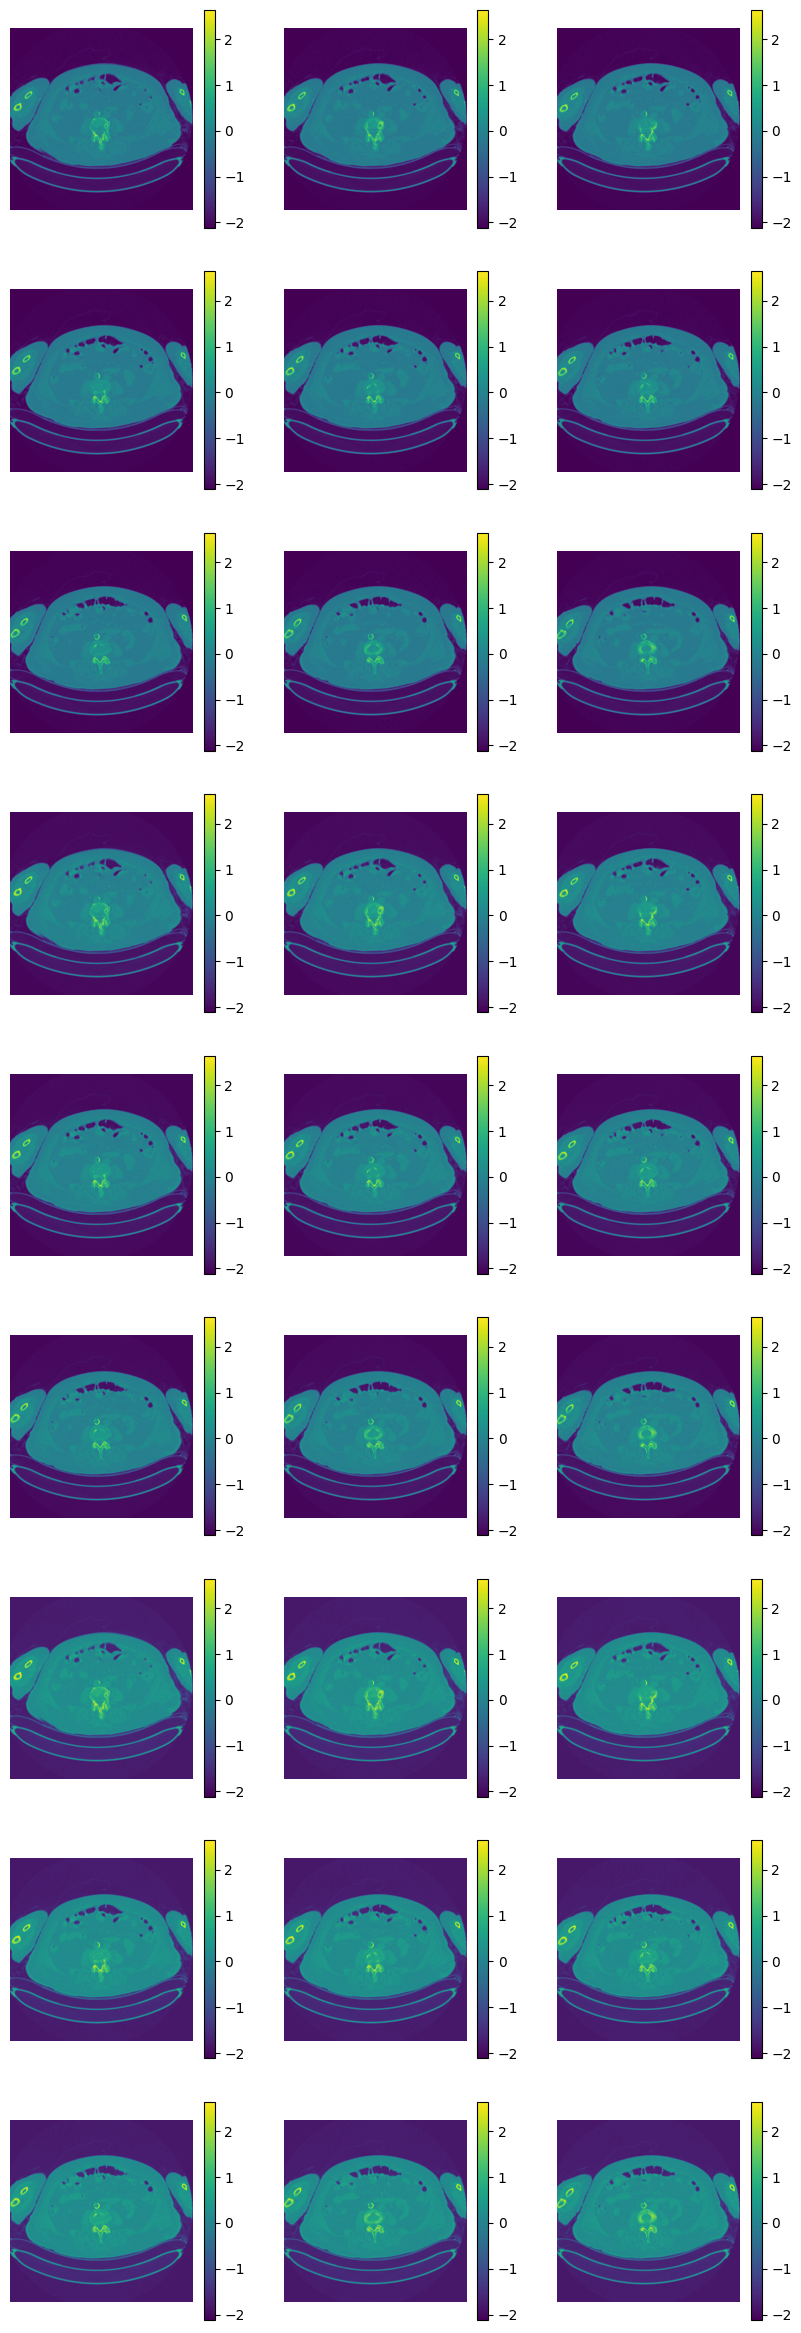

In [118]:
fig, ax = plt.subplots(9, 3, figsize=(10, 30))
for i in range(9):
    for j in range(3):
        img = ax[i, j].imshow(
            np.rot90(image_pre_final[i * 3 + j, :, :], k=1),
            vmax=torch.max(image_pre_final), vmin=torch.min(image_pre_final)
)
        ax[i, j].set_axis_off()
        plt.colorbar(mappable=img, ax=ax[i, j])

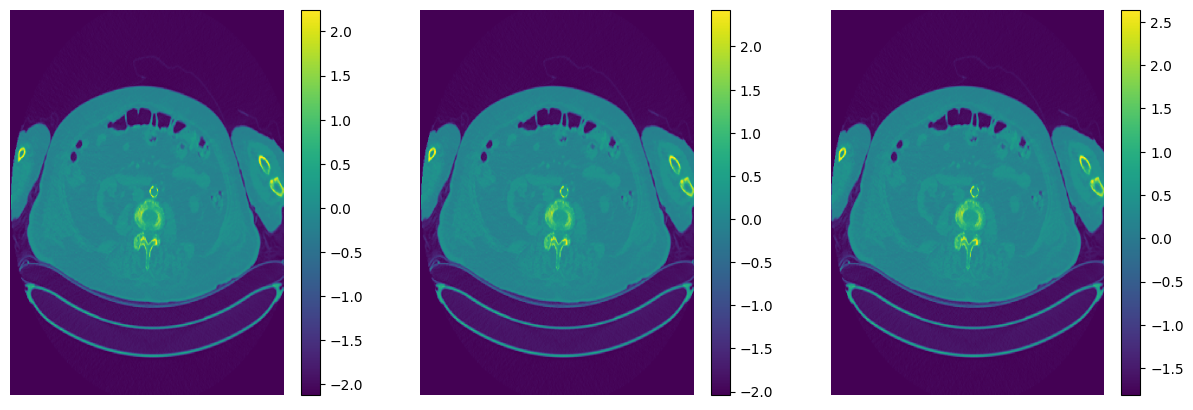

In [87]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    img = ax[i].pcolormesh(np.rot90(image_pre_chunk[8][i,...], k=3))
    plt.colorbar(ax=ax[i], mappable=img)
    ax[i].set_axis_off()

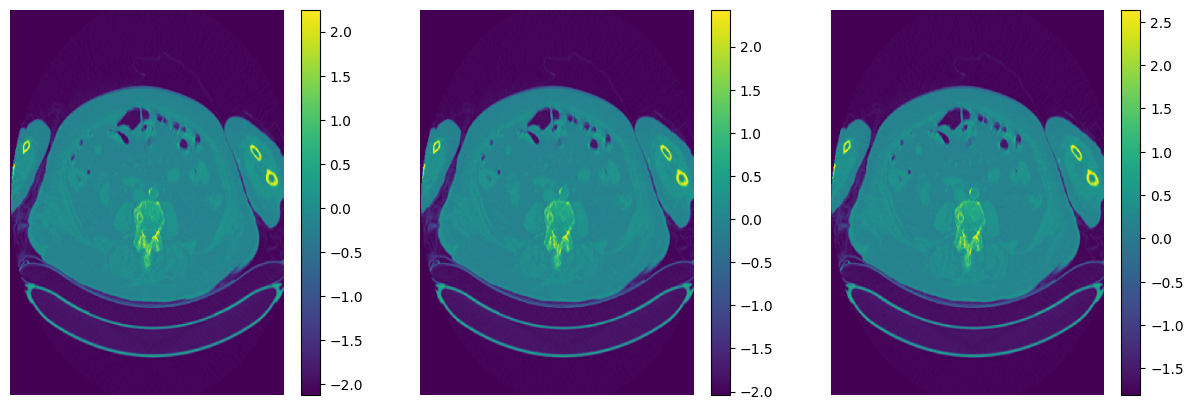

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    img = ax[i].pcolormesh(np.rot90(image_pre_chunk[0][i, ...], k=3))
    plt.colorbar(ax=ax[i], mappable=img)
    ax[i].set_axis_off()

In [105]:
image_pre_chunk = torch.chunk(image_pre, 9, dim=0)

In [112]:
image_pre_final = torch.stack(image_pre_chunk, dim=0)

In [113]:
image_pre_final.shape

torch.Size([9, 3, 1024, 1024])

In [108]:
from einops import rearrange

In [114]:
image_pre_final = rearrange(image_pre_final, 'b c h w -> (c b) h w')

In [117]:
torch.max(image_pre_final)


metatensor(2.6400)

In [137]:
def reor(tensor_ori):
    tensor_fin = torch.chunk(tensor_ori, tensor_ori.shape[0] // 3, dim=0)
    tensor_fin = torch.stack(tensor_fin, dim=0)
    return rearrange(tensor_fin, "b c h w -> (c b) h w")

In [129]:
image_reor = reor(image_pre)

In [138]:
image_reor_2 = reor(image_pre)

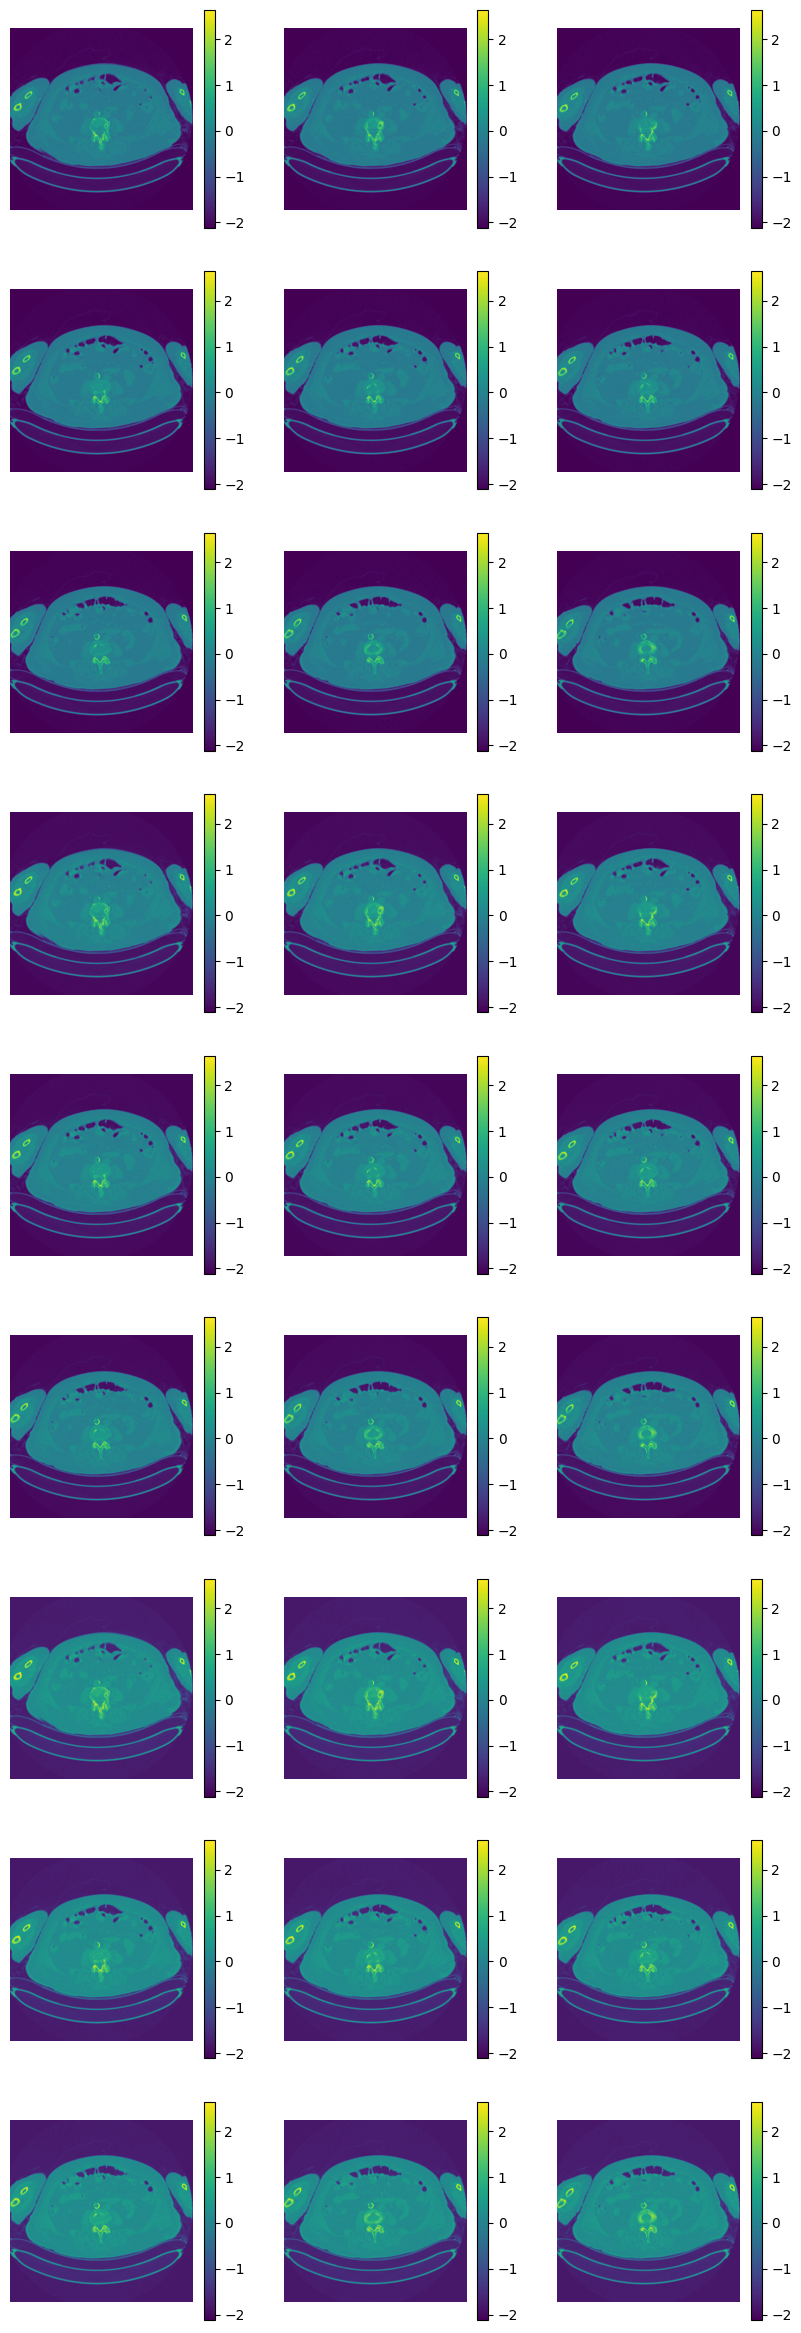

In [131]:
fig, ax = plt.subplots(9, 3, figsize=(10, 30))
for i in range(9):
    for j in range(3):
        img = ax[i, j].imshow(
            np.rot90(image_reor[i * 3 + j, :, :], k=1),
            vmax=torch.max(image_reor),
            vmin=torch.min(image_reor),
        )
        ax[i, j].set_axis_off()
        plt.colorbar(mappable=img, ax=ax[i, j])

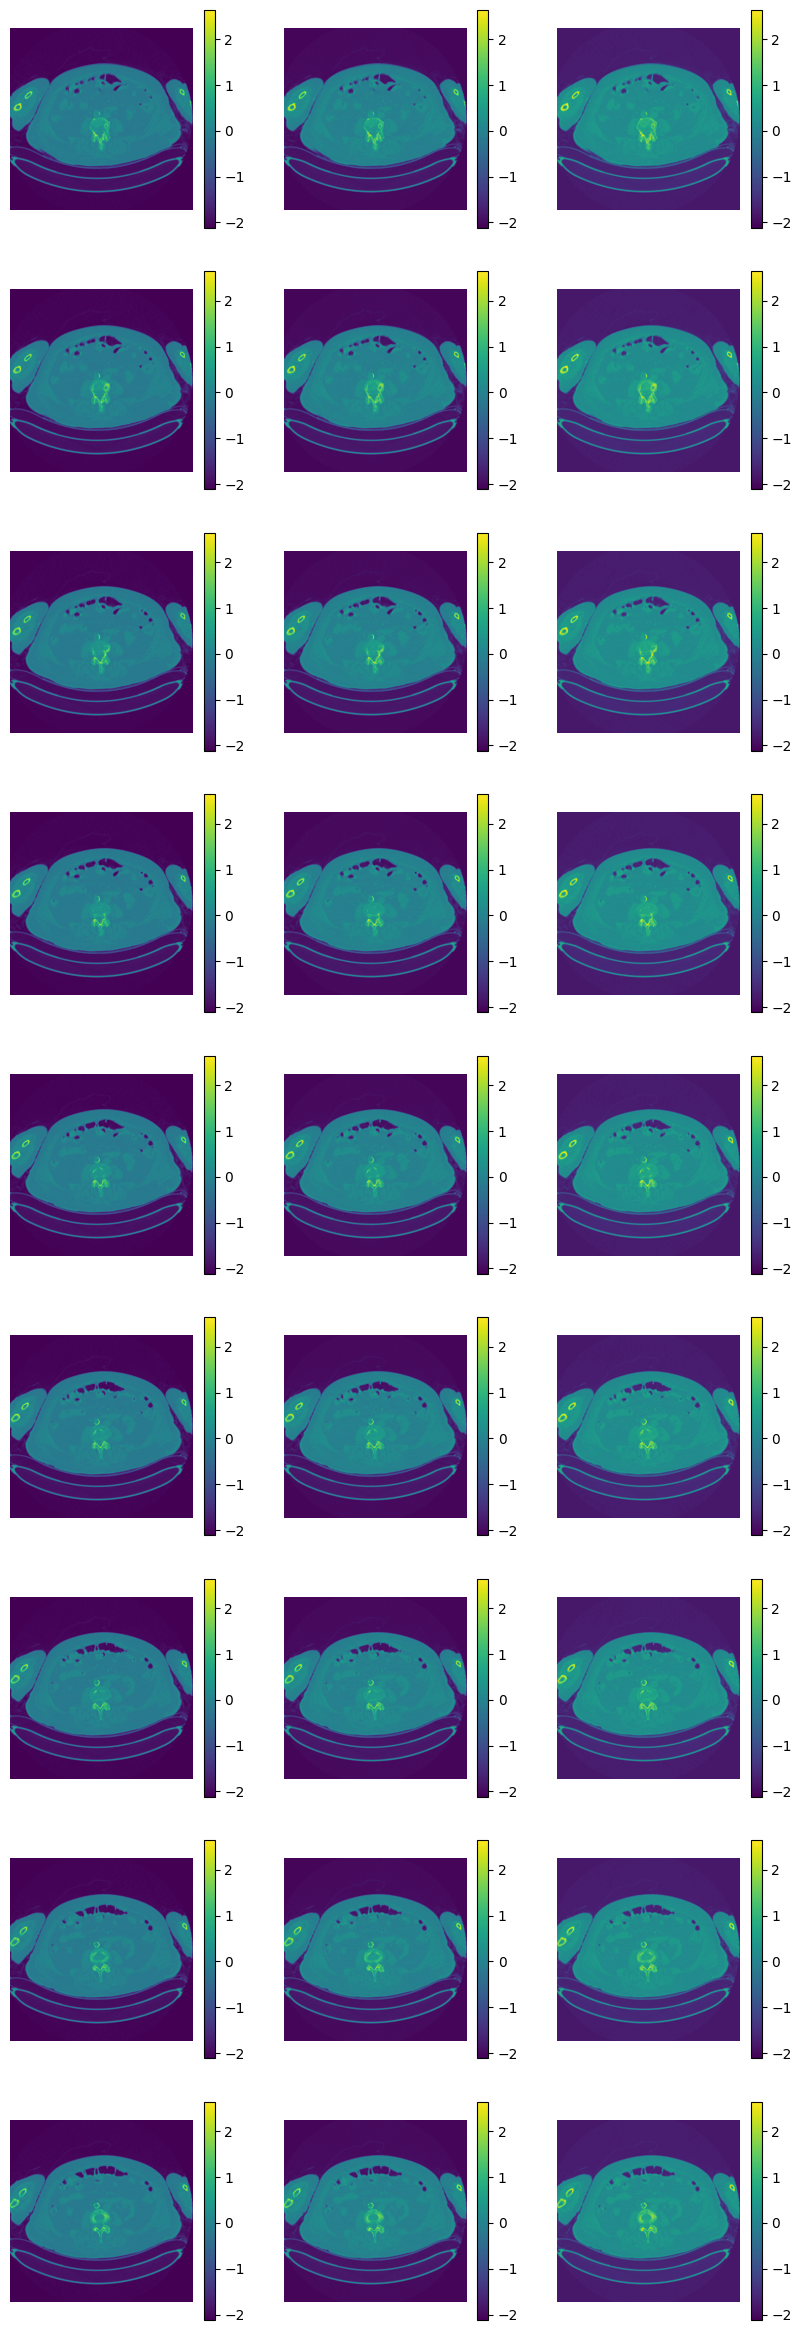

In [132]:
fig, ax = plt.subplots(9, 3, figsize=(10, 30))
for i in range(9):
    for j in range(3):
        img = ax[i, j].imshow(
            np.rot90(image_reor_2[i * 3 + j, :, :], k=1),
            vmax=torch.max(image_reor_2),
            vmin=torch.min(image_reor_2),
        )
        ax[i, j].set_axis_off()
        plt.colorbar(mappable=img, ax=ax[i, j])

In [168]:
state = torch.load("../../weight/mobile_sam.pt", map_location=torch.device("cpu"))

In [173]:
for k in state.keys():
    if 'mask_decoder' in k:
        print(k,'\n')


mask_decoder.transformer.layers.0.self_attn.q_proj.weight 

mask_decoder.transformer.layers.0.self_attn.q_proj.bias 

mask_decoder.transformer.layers.0.self_attn.k_proj.weight 

mask_decoder.transformer.layers.0.self_attn.k_proj.bias 

mask_decoder.transformer.layers.0.self_attn.v_proj.weight 

mask_decoder.transformer.layers.0.self_attn.v_proj.bias 

mask_decoder.transformer.layers.0.self_attn.out_proj.weight 

mask_decoder.transformer.layers.0.self_attn.out_proj.bias 

mask_decoder.transformer.layers.0.norm1.weight 

mask_decoder.transformer.layers.0.norm1.bias 

mask_decoder.transformer.layers.0.cross_attn_token_to_image.q_proj.weight 

mask_decoder.transformer.layers.0.cross_attn_token_to_image.q_proj.bias 

mask_decoder.transformer.layers.0.cross_attn_token_to_image.k_proj.weight 

mask_decoder.transformer.layers.0.cross_attn_token_to_image.k_proj.bias 

mask_decoder.transformer.layers.0.cross_attn_token_to_image.v_proj.weight 

mask_decoder.transformer.layers.0.cross_attn_token_t